## PixelCNN

PixelCNN is an autoregressive likelihood model for the task of image modeling.

### Reference
- https://keras.io/examples/generative/pixelcnn/
- Pixel Recurrent Neural Networks: https://arxiv.org/abs/1601.06759

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class MaskedConv2d(nn.Conv2d):
    """
    Implements a conv2d with mask applied on its weights.
    
    Args:
        mask_type (str): the mask type, 'A' or 'B'.
        in_channels (int) – Number of channels in the input image.
        out_channels (int) – Number of channels produced by the convolution.
        kernel_size (int or tuple) – Size of the convolving kernel
    """
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.mask_type = mask_type
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        mask = torch.zeros(kernel_size)
        mask[:kernel_size[0]//2, :] = 1.0
        mask[kernel_size[0]//2, :kernel_size[1]//2] = 1.0
        if self.mask_type == "B":
            mask[kernel_size[0]//2, kernel_size[1]//2] = 1.0
        self.register_buffer('mask', mask[None, None])
        
    def forward(self, x):
        self.weight.data *= self.mask # mask weights
        return super().forward(x)
    

class ResidualBlock(nn.Module):
    """
    Residual Block: conv1x1 -> conv3x3 -> conv1x1
    """
    
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 1),
            nn.ReLU(inplace=True)
        )
        # masked conv2d
        self.conv2 = nn.Sequential(
            MaskedConv2d("B", in_channels // 2, in_channels // 2, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels // 2, in_channels, 1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        inputs = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return inputs + x

In [3]:
class PixelCNN(nn.Module):
    """
    PixelCNN model
    """
    
    def __init__(self, in_channels=1, channels=128, out_channels=1, n_residual_blocks=5):
        super().__init__()
        
        # we use maskedconv "A" for the first layer
        self.stem = nn.Sequential(
            MaskedConv2d("A", in_channels, channels, 7, padding=3),
            nn.ReLU(inplace=True)
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(channels) for _ in range(n_residual_blocks)]
        )
        self.head = nn.Sequential(
            MaskedConv2d("B", channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            MaskedConv2d("B", channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, out_channels, 1)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.res_blocks(x)
        x = self.head(x)
        return x

In [4]:
image_size = 28
in_channels = 1
out_channels = 1
channels = 128 # hidden channels
n_residual_blocks = 5

batch_size = 128
epochs = 50

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('/data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('/data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = PixelCNN(in_channels, channels, out_channels, n_residual_blocks).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [5]:
print_freq = 500
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = (images > 0.33).float() # convert to 0, 1
        images = images.cuda()
        logits = model(images)
        loss = F.binary_cross_entropy_with_logits(logits, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))       

Start training epoch 0
	 [468/469]: loss 0.09943267703056335
Start training epoch 1
	 [468/469]: loss 0.08993204683065414
Start training epoch 2
	 [468/469]: loss 0.08632215857505798
Start training epoch 3
	 [468/469]: loss 0.0857618898153305
Start training epoch 4
	 [468/469]: loss 0.08323406428098679
Start training epoch 5
	 [468/469]: loss 0.08515626192092896
Start training epoch 6
	 [468/469]: loss 0.09080298990011215
Start training epoch 7
	 [468/469]: loss 0.0851127877831459
Start training epoch 8
	 [468/469]: loss 0.08575288951396942
Start training epoch 9
	 [468/469]: loss 0.08795469254255295
Start training epoch 10
	 [468/469]: loss 0.08480170369148254
Start training epoch 11
	 [468/469]: loss 0.08301049470901489
Start training epoch 12
	 [468/469]: loss 0.08615297824144363
Start training epoch 13
	 [468/469]: loss 0.08480261266231537
Start training epoch 14
	 [468/469]: loss 0.08743501454591751
Start training epoch 15
	 [468/469]: loss 0.08629097044467926
Start training epoch

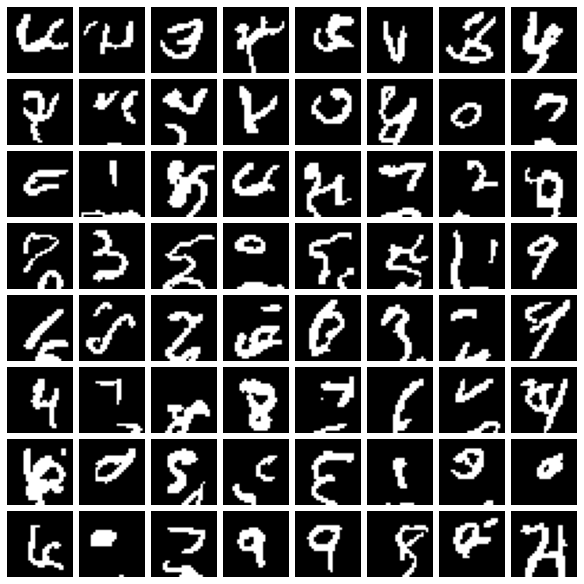

In [6]:
## generate new images by PixelCNN
n_cols, n_rows = 8, 8
C = 1
H = 28
W = 28

# Create an empty array of pixels.
pixels = torch.zeros(n_cols * n_rows, C, H, W).cuda()

model.eval()
with torch.no_grad():
    # Iterate over the pixels because generation has to be done sequentially pixel by pixel.
    for h in range(H):
        for w in range(W):
            for c in range(C):
                # Feed the whole array and retrieving the pixel value probabilities for the next pixel.
                logits = model(pixels)[:, c, h, w]
                probs = logits.sigmoid()
                # Use the probabilities to pick pixel values and append the values to the image frame.
                pixels[:, c, h, w] = torch.bernoulli(probs)
                
generated_imgs = pixels.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, H, W)
    
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")